In [24]:
#Library Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import cv2

In [25]:
#paths...
data_path = "./Database"
image_path = os.path.join(data_path, "Image")
label_file = os.path.join(data_path, "Label.txt")

#labels...
def load_labels(label_path):
    labels = pd.read_csv(label_path, sep="\t", header=None, names=["Image", "Pitch", "Roll", "Depth"])
    return labels



#images....
#resize cnn models
#extrcat pitch, roll, depth
def load_images(labels_df, image_folder):
    images = []
    labels = []
    
    for _, row in labels_df.iterrows():
        img_file = os.path.join(image_folder, row["Image"])
        if os.path.exists(img_file):
            img = cv2.imread(img_file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))  
            images.append(img)
            labels.append(row[1:].values) 
        
    return np.array(images), np.array(labels)

labels_df = load_labels(label_file)
images, labels = load_images(labels_df, image_path)



/Users/annabelsimpson/anaconda3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/annabelsimpson/anaconda3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

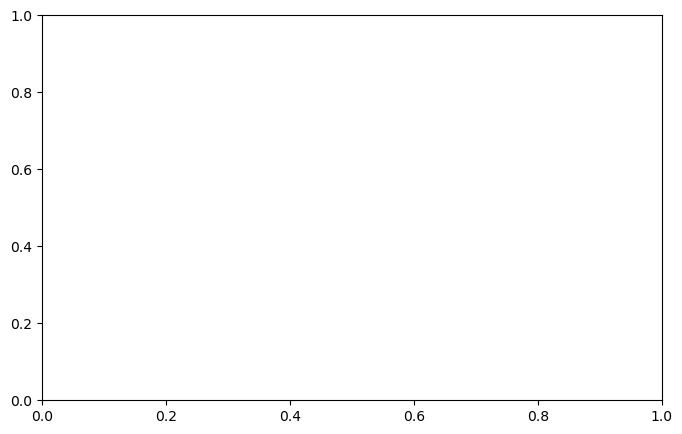

In [26]:

#EDA visualisation....
def plot_label_distribution(labels_df):
    plt.figure(figsize=(8, 5))
    plt.hist(labels_df["Pitch"], bins=20, alpha=0.7, label="Pitch")
    plt.hist(labels_df["Roll"], bins=20, alpha=0.7, label="Roll")
    plt.hist(labels_df["Depth"], bins=20, alpha=0.7, label="Depth")
    plt.legend()
    plt.title("Label Distributions")
    plt.show()
plot_label_distribution(labels_df)


#plot_samples(images, labels)

labels_df = load_labels(label_file)
labels_df.dropna(inplace=True) 
images, labels = load_images(labels_df, image_path)

if len(images) == 0 or len(labels) == 0:
    print("Error: No images or labels loaded. Verify image paths and Labels.txt format.")
else:
    plot_label_distribution(labels_df)


In [27]:

# normalisation...
images = images / 255.0
labels[:, 2] = (labels[:, 2] - labels[:, 2].mean()) / labels[:, 2].std()



#splitting data...
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# print("Labels shape:", labels.shape)
# if labels.ndim == 1:
#     labels = labels.reshape(-1, 3) 




IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [28]:
#data augmentation...
augmenter = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True
)

In [29]:
#CNN classification...
#binary classificatoin for pitch + roll
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn((224, 224, 3))



In [30]:
#training....
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('cnn_best_model.keras', save_best_only=True, monitor='val_accuracy')
history_cnn = cnn_model.fit(
    augmenter.flow(X_train, y_train[:, :2], batch_size=128),
    validation_data=(X_val, y_val[:, :2]),
    epochs=25,
    callbacks=[checkpoint]
)


NameError: name 'X_train' is not defined

In [31]:
#training visualisation...
def plot_training(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_training(history_cnn)

NameError: name 'history_cnn' is not defined

In [32]:
#regression model...
def build_regression_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

regression_model = build_regression_model((224, 224, 3))


In [33]:
#training regression...
checkpoint_regression = ModelCheckpoint('regression_best_model.h5', save_best_only=True, monitor='val_loss')

history_regression = regression_model.fit(
    augmenter.flow(X_train, y_train[:, 2], batch_size=128),
    validation_data=(X_val, y_val[:, 2]),
    epochs=25,
    callbacks=[checkpoint_regression]
)


NameError: name 'X_train' is not defined

In [34]:
#evalution + visuallisation of regression...
def plot_regression_results(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.legend()
    plt.title('Mean Absolute Error')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_regression_results(history_regression)

NameError: name 'history_regression' is not defined

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = cnn_model.predict(X_val)
print(classification_report(y_val[:, :2].argmax(axis=1), y_pred.argmax(axis=1)))
print(confusion_matrix(y_val[:, :2].argmax(axis=1), y_pred.argmax(axis=1)))


NameError: name 'X_val' is not defined

In [36]:
from sklearn.metrics import mean_squared_error

y_pred = regression_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val[:, 2], y_pred))
print(f"RMSE: {rmse:.3f}")


NameError: name 'X_val' is not defined

In [37]:
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("CNN Classification Accuracy")
plt.show()


NameError: name 'history_cnn' is not defined